In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [156]:
# 데이터셋 가져오기
df = pd.read_csv("housingdata.csv")

- 히스토그램으로 각 컬럼별 데이터 분포 확인

<Figure size 1500x1000 with 0 Axes>

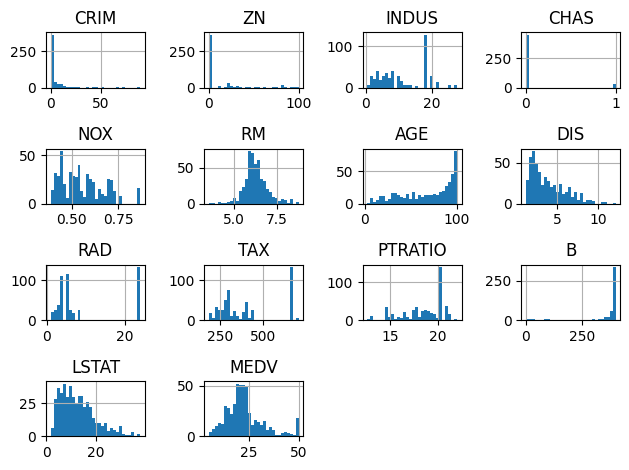

In [157]:
# 1. 히스토그램
plt.figure(figsize=(15, 10))
df.hist(bins=30)
plt.tight_layout()
plt.show()

- 히트맵으로 각 컬럼과의 상관계수 확인

In [158]:
# 결측치 처리
from sklearn.impute import SimpleImputer

imputer_1 = SimpleImputer(strategy='mean')              # 평균값 객체 생성
imputer_2 = SimpleImputer(strategy='median')            # 중앙값 객체 생성
imputer_3 = SimpleImputer(strategy='most_frequent')     # 최빈값 객체 생성

df['CRIM'] = imputer_3.fit_transform(df[['CRIM']])      # 히스토그램을 보면 최빈값의 비율이 압도적이기 떄문에 최빈값으로 처리
df['ZN'] = imputer_3.fit_transform(df[['ZN']])          # 히스토그램을 보면 최빈값의 비율이 압도적이기 떄문에 최빈값으로 처리
df['INDUS'] = imputer_2.fit_transform(df[['INDUS']])    # 중앙값과 평균값이 비슷하기에 중앙값으로 처리
df['CHAS'] = imputer_3.fit_transform(df[['CHAS']])      # 대부분의 값이 0이기 때문에 최빈값으로 처리
df['AGE'] = imputer_2.fit_transform(df[['AGE']])        # 데이터가 연속적이고 평균값이 중앙값이 비슷하기에 중앙값으로 대체
df['LSTAT'] = imputer_2.fit_transform(df[['LSTAT']])    # 데이터가 연속적이고 평균값이 중앙값이 비슷하기에 중앙값으로 대체
# df = df.sort_values(by="TAX").reset_index(drop=True)        # TAX 값을 기준으로 오름차순 정렬
# df['TIME'] = (df['TAX'] != df['TAX'].shift()).cumsum()      # TAX가 10,000$ 당 세금이기 때문에 TAX가 오르면 년도가 달라질꺼라고 예측하고 시간적 데이터 'TIME'컬럼을 추가함
# 적용했을 때 예측값이 더 낮게 나옴, 아마 기존 TAX 컬럼보다 종속변수와의 상관계수가 낮고 TAX와 TIME컬럼이 상관계수가 높은기 때문으로 추정
# 따라서 주석처리

df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

> 결측치 처리는 데이터 전처리 과정 중 엄청 중요한 과정임<br>
> 어떻게 처리하느냐에 따라 모델 설명력(r2_score)이 보스턴 주택가격 데이터셋에서는 10~20% 정도 차이가 났음
-------
- 히트맵으로 각 컬럼 별 상관계수를 확인

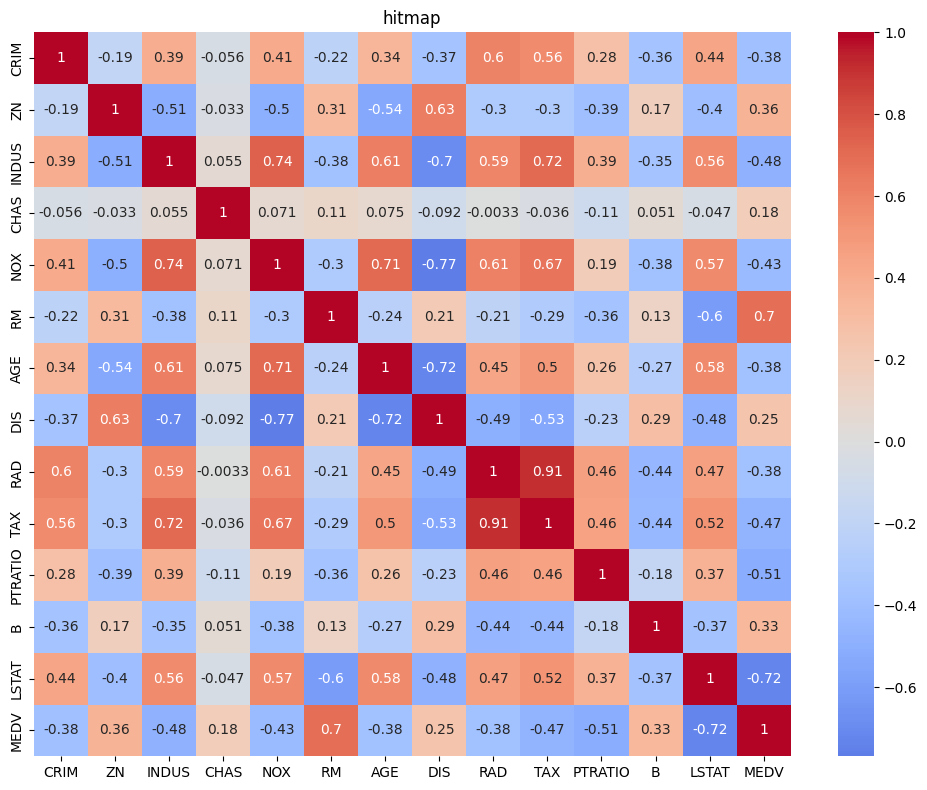

In [159]:
import seaborn as sns
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('hitmap')
plt.tight_layout()
plt.show()

- 종속변수와 관계가 낮은 하위 4개의 컬럼을 제외

In [160]:
from sklearn.model_selection import train_test_split


X = df[['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']]                 # 특징 선택 : 종속변수와 상관계수가 낮은 하위 4개컬럼 제거, 종속변수와 분리
y = df[["MEDV"]]                                                                                # 종속변수 지정
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)       # 훈련데이터와 테스트데이터 나누기

- 스탠다드 스케일링

In [161]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

- 이상치 처리를 위한 코드(이상치를 lowerbound, upperbound 값으로 대체)
> 데이터가 너무 작기에 이상치를 제거하면 데이터 손실이 크고<br>
> 데이터를 대체하기에도 데이터가 매우 작기에 데이터의 순수성을 크게 해칠 수있음<br>
> 집값같은 경우 극단적인 요소도 집값에 큰 영향을 미칠 수 있기 떄문에 이상치 처리를 생략함<br>

* 모델평가도 이상치 처리를 생략할 때 더 높게 나옴

In [162]:
# #이상치를 구간값의 lower_bound, upper_bound로 대체
# for i in X_train.columns:
#     Q1 = X_train[i].quantile(0.25)
#     Q3 = X_train[i].quantile(0.75)
#     IQR = Q3 - Q1

#     # 이상치 범위 설정 
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR


#     # 이상치 처리
#     X_train[i] = X_train[i].clip(lower = lower_bound, upper = upper_bound)
# print(len(X_train.index))
# #y_train = y_train[X_train.index] # y_train도 X_train에 맞춰서 조정

- 모델과의 성능 비교를 위해 4개의 모델을 학습시키고 성능지표를 생성

In [163]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

model_Lin = LinearRegression()                                                                          # 선형회기
model_Rid = Ridge(alpha=1.0)                                                                            # 리지회귀
model_Las = Lasso(alpha=1.0)                                                                            # 라쏘회귀
model_Ran = RandomForestRegressor(n_estimators=100, random_state=42)                                    # 랜덤포레스트, 학습기의 갯수 100개개

# 모델 학습
model_Lin.fit(X_train,y_train)
model_Rid.fit(X_train,y_train)
model_Las.fit(X_train,y_train)
model_Ran.fit(X_train,y_train)

# 예측값 생성
y_pred_Lin = model_Lin.predict(X_test)
y_pred_Rid = model_Rid.predict(X_test)
y_pred_Las = model_Las.predict(X_test)
y_pred_Ran = model_Ran.predict(X_test)


# 예측값과 실제값으로 모델평가
mae_Lin = mean_absolute_error(y_test, y_pred_Lin)
mae_Rid = mean_absolute_error(y_test, y_pred_Rid)
mae_Las = mean_absolute_error(y_test, y_pred_Las)
mae_Ran = mean_absolute_error(y_test, y_pred_Ran)


# 오차평균
mse_Lin = mean_squared_error(y_test, y_pred_Lin)
mse_Rid = mean_squared_error(y_test, y_pred_Rid)
mse_Las = mean_squared_error(y_test, y_pred_Las)
mse_Ran = mean_squared_error(y_test, y_pred_Ran)



# 모델의 설명력을 나타내는 지표 / 예측값이 얼마나 잘 맞는지를 0~1사이로 나타낸 지표
r2_Lin = r2_score(y_test, y_pred_Lin)
r2_Rid = r2_score(y_test, y_pred_Rid)
r2_Las = r2_score(y_test, y_pred_Las)
r2_Ran = r2_score(y_test, y_pred_Ran)

# print(f'mae ------> {mae}')
# print(f'mse ------> {mse}')
# print(f'r2 ------> {r2}')


c:\Users\LEE\anaconda3\envs\mlenv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


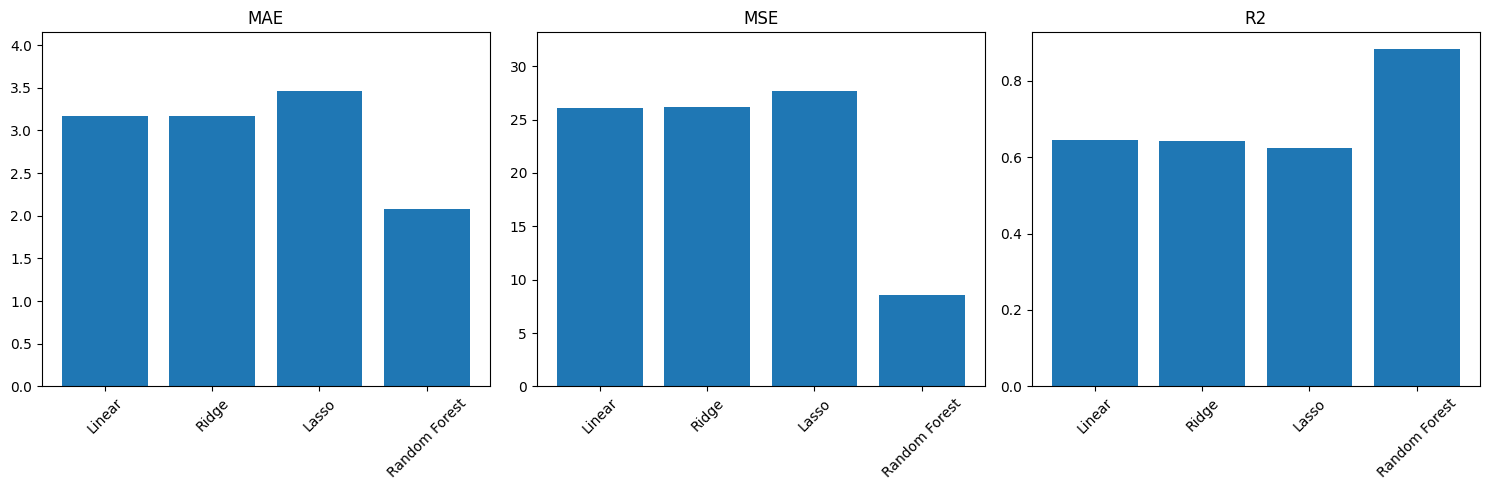

In [164]:
# 성능 지표를 딕셔너리로 정리
metrics = {
    'MAE': [mae_Lin, mae_Rid, mae_Las, mae_Ran],
    'MSE': [mse_Lin, mse_Rid, mse_Las, mse_Ran],
    'R2': [r2_Lin, r2_Rid, r2_Las, r2_Ran]
}

models = ['Linear', 'Ridge', 'Lasso', 'Random Forest']

# 그래프 생성
plt.figure(figsize=(15, 5))

# MAE, MSE, R2 각각에 대한 서브플롯 생성
for i, (metric, values) in enumerate(metrics.items(), 1):
    plt.subplot(1, 3, i)
    plt.bar(models, values)
    plt.title(f'{metric}')
    plt.xticks(rotation=45)
    if metric != 'R2':  # R2는 이미 0~1 사이 값이므로 제외
        plt.ylim(0, max(values) * 1.2)

plt.tight_layout()
plt.show()

- 성능 비교결과 랜덤포레스트 모델이 가장 성능이 뛰어남(랜덤포레스트 선택) 
------
- 랜덤포레스트의 모델 평가 수치 확인

In [165]:
# 랜덤포레스트 모델 평가 수치 확인
print(f'mae ------> {mae_Ran}')  # 절대 오차의 평균                                           
print(f'mse ------> {mse_Ran}')  # 오차 제곱의 평균
print(f'r2 ------> {r2_Ran}')    # 모델의 변동성을 얼마나 잘 설명하는지를 0~1사이의 값으로 나타낸 지표

mae ------> 2.0792647058823532
mse ------> 8.611369460784319
r2 ------> 0.88257295492368


- 모델의 예측 가격과 실제 가격(MEDV)을 비교하는 산점도 확인

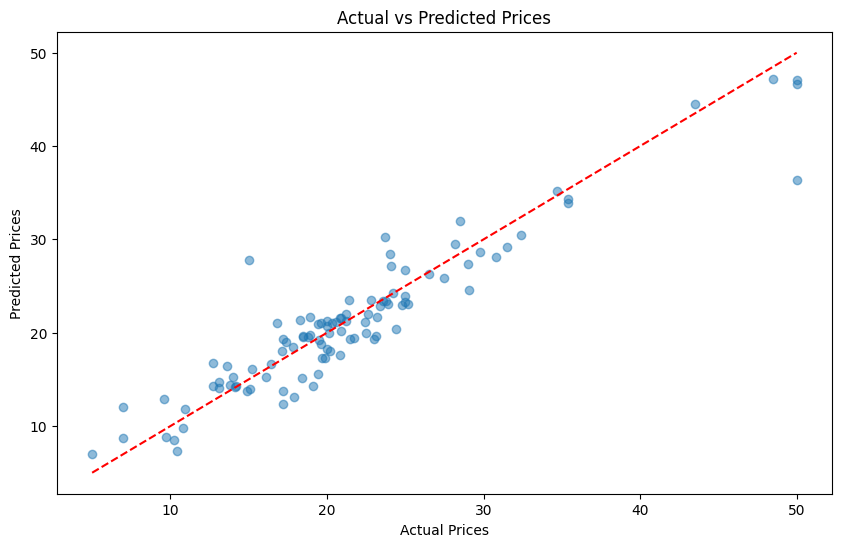

In [166]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_Ran, alpha=0.5)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--') # y=x 선 추가
plt.show()

- 산점도를 보았을 떄 주택의 실제 가격과 예측 가격을 매우 잘 예측하는 듯 함

## 결론
- 이 데이터셋에서 선형회귀, 리지회귀, 라쏘회귀, 랜덤포레스트 이 4개의 모델 중 가장 성능이 좋은 것은 랜덤포레스트이다.
- 결측치 처리는 매우매우매우 중요하다.
- 데이터셋이 너무 작을 때에는 이상치 처리를 하지 않는것도 좋은 방법이다.(데이터셋의 특성을 고려해야함)
--------

## 도전과제

- 1.앙상블 기법 적용하기

In [167]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

model_Bag = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42)      # 배깅
model_Gra = GradientBoostingRegressor(n_estimators=100, random_state=42)                                # 그레디언트부스팅
model_Xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=7, random_state=42)         # xg부스트

model_Bag.fit(X_train,y_train)
model_Gra.fit(X_train,y_train)
model_Xgb.fit(X_train,y_train)

y_pred_Bag = model_Bag.predict(X_test)
y_pred_Gra = model_Gra.predict(X_test)
y_pred_Xgb = model_Xgb.predict(X_test)

mae_Bag = mean_absolute_error(y_test, y_pred_Bag)
mae_Gra = mean_absolute_error(y_test, y_pred_Gra)
mae_Xgb = mean_absolute_error(y_test, y_pred_Xgb)

mse_Bag = mean_squared_error(y_test, y_pred_Bag)
mse_Gra = mean_squared_error(y_test, y_pred_Gra)
mse_Xgb = mean_squared_error(y_test, y_pred_Xgb)

r2_Bag = r2_score(y_test, y_pred_Bag)
r2_Gra = r2_score(y_test, y_pred_Gra)
r2_Xgb = r2_score(y_test, y_pred_Xgb)

c:\Users\LEE\anaconda3\envs\mlenv\Lib\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\LEE\anaconda3\envs\mlenv\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


C:\Users\LEE\AppData\Local\Temp\ipykernel_55948\757950283.py:20: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LEE\AppData\Local\Temp\ipykernel_55948\757950283.py:20: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\LEE\anaconda3\envs\mlenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\LEE\anaconda3\envs\mlenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


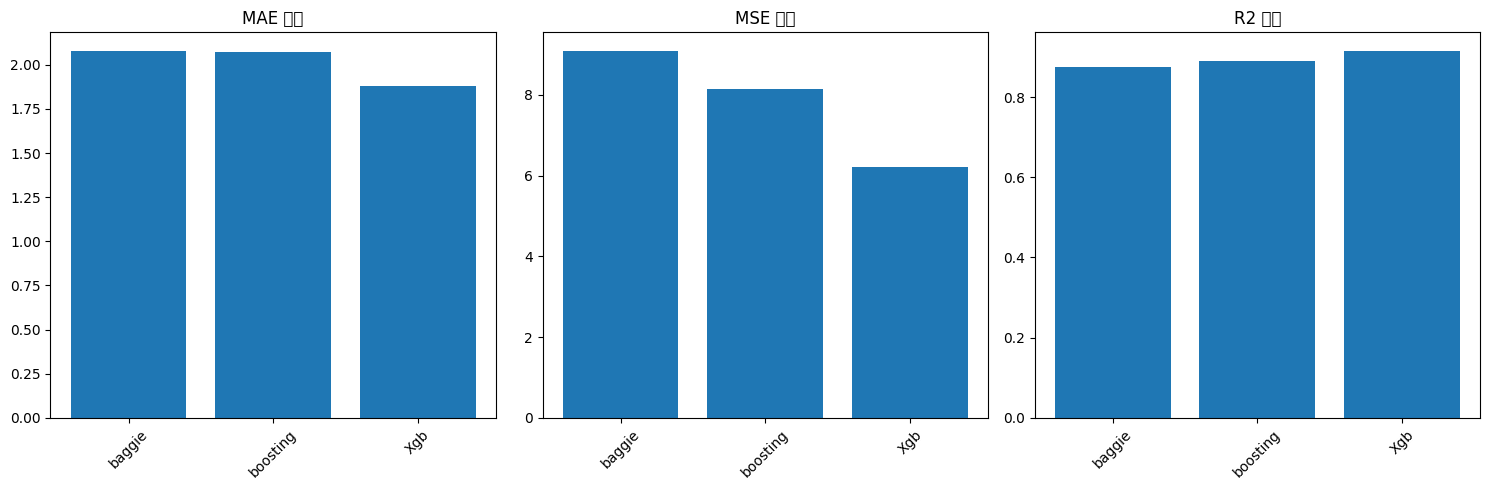

In [168]:
# 성능 지표를 딕셔너리로 정리
metrics = {
    'MAE': [mae_Bag, mae_Gra, mae_Xgb],
    'MSE': [mse_Bag, mse_Gra, mse_Xgb],
    'R2': [r2_Bag, r2_Gra, r2_Xgb]
}

models = ['baggie','boosting', 'Xgb']

# 그래프 생성
plt.figure(figsize=(15, 5))

# MAE, MSE, R2 각각에 대한 서브플롯 생성
for i, (metric, values) in enumerate(metrics.items(), 1):
    plt.subplot(1, 3, i)
    plt.bar(models, values)
    plt.title(f'{metric} 비교')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

- XGB 모델이 가장 성능이 좋음(XGB 모델 선택)
-------
- 2. 하이퍼 파라미터 튜닝(도전과제 2)

In [169]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# 그리드 서치를 위한 파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 6, 7],                     # 기존에 썼던 max_depth 값 7을 포함시킴
    'learning_rate': [0.01, 0.1],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}

xgb = XGBRegressor(random_state=42)

# GridSearchCV 객체 생성
grid_search = GridSearchCV(
    estimator=xgb,                              # XGB 모델 선택
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# 그리드 서치 수행
grid_search.fit(X_train, y_train)

# 최적의 파라미터 출력
print("최적 파라미터:", grid_search.best_params_)
print("최적 점수:", np.sqrt(-grid_search.best_score_))
print(f'{'------'* 10}')

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {np.sqrt(mse):.4f}')
print(f'R2 Score: {r2:.4f}')
print(f'{'------'* 10}')

# 기존 모델 평가 수치 확인
print(f'기존mae ------> {mae_Xgb}')                                        
print(f'기존mse ------> {mse_Xgb}')
print(f'기존r2 ------> {r2_Xgb}')


Fitting 5 folds for each of 192 candidates, totalling 960 fits
최적 파라미터: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
최적 점수: 3.8784412460466267
------------------------------------------------------------
RMSE: 2.7040
R2 Score: 0.9003
------------------------------------------------------------
기존mae ------> 1.8785795323988967
기존mse ------> 6.199689176465052
기존r2 ------> 0.9154592752456665


c:\Users\LEE\anaconda3\envs\mlenv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


- 기존 평가값이랑 비교했을 때 r2 스코어 값은 비슷하고(교차검증이기에 값이 조금 떨어질 수 있음)
- MSE 값은 매우 많이 낮아짐